In [ ]:
!pip install wget
!pip install clean-text
!pip install torchtext==0.6.0
!pip install  sentencepiece  
!pip install transformers==2.8.0

import re
import os
import csv
import time
import math
import json
import random
import collections
import numpy as np
import pandas as pd
from cleantext import clean
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchtext import data
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel, DistilBertTokenizer, DistilBertModel, GPT2Tokenizer, GPT2LMHeadModel 
from torchsummary import summary
from torchtext.data.metrics import bleu_score
from tqdm.autonotebook import tqdm

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=5fc62fa37744ce9093dc26e0b7868f9f9d2d91f37893e3446e93d7992dd2f8ec
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 51kB 4.9MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49716 sha256=a64e446506ceb4c5ee347ad672d4f87b2b4cbbab622328400c7cb6363f73fcd9
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45612 sha256=51fb6eb3f72d485b8ce8fb97588ce99ba3ac011b233e9b4a87bf3f1277cedf6d
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built emoji ftfy
     |████████████████████████████████| 71kB 6.7MB/s 
     |███████████████████

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


### **Constants And Required Functions**

**Data Preprocessing**

In [ ]:
"""
Device
"""
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

"""
Batch Size
"""
BATCH_SIZE= 6

isTrain = False

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(915)


def textPreprocess(txt):
    """
    Convert to Lowercase and Trim the text
    """
    txt = txt.lower().strip()

    """
    Fix various unicode errors
    transliterate to closest ASCII representation
    """
    txt = clean(txt, fix_unicode=True, to_ascii=True)

    """
    Removing zero-width character
    """
    txt = re.sub(u"\ufe0f", r" ", txt)

    """
    Remove URL
    """
    txt = re.sub(r"https?://[A-Za-z0-9./]*", r" ", txt)

    """
    Remove Specific Special character
    """
    txt = re.sub(r"[-.!?()_]+", r" ", txt)
    """
    Remove charatcter like special characters, punctuations except alphanumeric charatcter.
    """
    txt = re.sub(r"[^0-9a-zA-Z]+", r" ", txt)

    """
    Remove Extra spaces which are appearing from previous processing steps.
   """
    txt = re.sub(r"\s+", r" ", txt).strip()
    return txt

**Required Directories Creation**

In [ ]:
"""
Required functions for directory creation
"""
def check_if_dir_exists(directory):
    """
    Checks if 'directory' exists
    """
    return(os.path.isdir(directory))

def make_dir(directory):
    """
    Create directory
    """
    if not check_if_dir_exists(directory):
        os.mkdir(directory)
        print("Directory %s created successfully." %directory)
    else:
        print("Directory %s exists." %directory)

print("We are in:",os.getcwd())

"""
Required directory creation
"""
chatbot_dir="/content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta"
make_dir(chatbot_dir)

os.chdir("/content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta")

chatbot_data_dir = chatbot_dir + "/ChatBot_Data/"
make_dir(chatbot_data_dir)

chatbot_result_dir = chatbot_dir + "/ChatBot_Results/"
make_dir(chatbot_result_dir)

chatbot_checkpoint_dir = chatbot_dir + "/ChatBot_Checkpoint/"
make_dir(chatbot_checkpoint_dir)

print(chatbot_data_dir)

We are in: /content
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta exists.
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/ exists.
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Results/ exists.
Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Checkpoint/ exists.
/content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/


**Listing Directories**

In [ ]:
def list_dir(dir_path):
  """
  List directories for a given path
  """
  print("Directory %s contains : " %dir_path)
  for dir_or_file in os.listdir(dir_path):
    print(dir_or_file)
  print("\n")

"""
List created directories
"""
print('Current directory : ', os.getcwd(),'\n')
list_dir(chatbot_dir)
list_dir(chatbot_data_dir)
list_dir(chatbot_checkpoint_dir)

Current directory :  /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta 

Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta contains : 
ChatBot_Data
ChatBot_Results
ChatBot_Checkpoint
.vector_cache
Images


Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Data/ contains : 
.kaggle
dev_v2.1.json.gz
dev_v2.1.json
question_asked.tsv
QAWhats.tsv
twcs.csv
QA_Pair.tsv
Apple_QA_Pair.tsv
Q_asked
question_asked


Directory /content/gdrive/My Drive/DATA_SCIENCE_Capstone_Project_ChatBot_Sofia_Dutta/ChatBot_Checkpoint/ contains : 
QA_Seq2Seq_ChatBot_BestModel.pt
QA_Seq2Seq_ChatBot.pt
QA_GPT_Seq2seq_ChatBot.pt
QA_GPT_Seq2seq_Results.csv
Apple_QA_Seq2Seq_ChatBot.pt
Apple_QA_Seq2Seq_ChatBot_BestModel.pt
Apple_QA_GPT_Seq2seq_ChatBot.pt
Apple_QA_GPT_Seq2seq_Results.csv




# **Chatbot Seq2Seq Model using Transformer Combined with GPT2**

## **Motivation**
  * RNN's do not scale up easily.
  * Successful deep learning models are the ones that get trained on hundreds of gigabytes of data with deeper neural network layers and commonly using dozens of GPUs.
  * This is where Transformer approach is valuable. As per [Vashwani et. al.](https://arxiv.org/abs/1706.03762), RNNs and Transformers are both similar in design and can handle sequential data, for example text data in natural language. However, the subtle difference being that Transformers do not need to process data in order. Thus if the input data were to be text from a natural language source, Transformer does not need to process the words in sequence from beginning to end. This allows Transformer to take advantage of massive amounts of parallelization using GPUs.

**Benefits of using a Transformer**

* Transformer processes all $T$ timesteps simultaneously, where the RNN process them sequentially. Transformer has many layers and involve a large number of computations and as the sequences get longer, the advtanges of the transformer improve.
* Transformers also benefit from larger layers and more layers, to a degree that RNNs do not usually with 3 layers and 512 neurons per layer.  Hence, transformers is sucesfull with large outputs. 
* But, that also increases the computational cost. It often uses hundreds and even _thousands_ of GPUs. This can make them prohibitively expensive.  
* Due to all these benefits, Transformer have become exceedingly popular. They tend work well for improving accuracy for problems that require training on lots of data by performing massive amounts of parallel computations.


## **Seq2Seq Model with Transformer, DistilBert Tokenizer and GPT2 Fine Tuning**

The heart of chatbot is a sequence-to-sequence (seq2seq) model. The goal of a seq2seq model is to take a variable-length question sequence as an input, and return a variable-length answer sequence as an output.

***Components :***

* I have used ***`DistilBertModel`***(i.e. `distilbert-base-uncased`)  layer to convert tokens into feature vectors. The purpose of the embedding layer is to convert tokens into feature vectors. 

> ***Bert*** : "*Bidirectional Encoder Representations from Transformers*"

> ***DistilBERT*** : a distilled version of BERT: smaller, faster, cheaper and lighter.

* Next, for encoder I have used `nn.TransformerEncoder`, an encoding transformer that takes a tensor of shape $(T, B, D)$ . It expects all $T$ items at once. The purpose of the encoder is to encode a variable length question sequence to a fixed-length context vector. This context vector will contain semantic information about the question.

* For decoder I have used `TransformerDecoder`, and ***`GPT2LMHeadModel`***(i.e. `distilgpt2`). It generates the output one item at a time. The end goal of the decoder layer is to take as input, a word and a context vector, and predict the next word in the sequence.

> ***GPT-2*** : “*Generative Pretrained Transformer 2*”

> * ***GPT2LMHeadModel*** : "*The GPT2 Model transformer with a language modeling head on top.*"


## **Dataset and  DataLoader Creation**

* For embedding ***`DistilBertModel`***(i.e. `distilbert-base-uncased`) is used with ***`DistilBertTokenizer`***(i.e. `distilbert-base-uncased`) in order to have exact same encoding process that is used by the original ***`DistilBertModel`*** training to convert new strings into inputs for ***`DistilBert`*** tokenization.

* Number of hidden neurons $D$ that ***`DistilBertModel`*** is using with the `BERT_MODEL.config.dim` . `.config` variable of huggingface model contains information of model configuration.

* From ***`BERT_TOKENIZER`*** taking `vocab_size`, `cls_token_id`, `sep_token_id`, `pad_token_id` as vocabulary size, start of sentence, end of sentence, padding for sentence to make variable length sentence padde upto max lenth with this pad token to make variable length sentence of same size. 

-----------------------------

Some information on BERT and other algorithms as explained by their docs for reference to papers read:

* **[Bert](https://huggingface.co/transformers/model_doc/bert.html)**
* > *We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models, BERT is designed to pre-train deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be fine-tuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial task-specific architecture modifications.*

* **[DistilBert](https://huggingface.co/transformers/model_doc/distilbert.html)** and **[DistilBERT Paper](https://arxiv.org/pdf/1910.01108.pdf)**
* > "*As Transfer Learning from large-scale pre-trained models becomes more prevalent in Natural Language Processing (NLP), operating these large models in on-the-edge and/or under constrained computational training or inference budgets remains challenging. In this work, we propose a method to pre-train a smaller general-purpose language representation model, called DistilBERT, which can then be fine-tuned with good performances on a wide range of tasks like its larger counterparts.*"

* **[GPT2](https://huggingface.co/transformers/model_doc/gpt2.html)**

* > ***GPT-2*** : “*Generative Pretrained Transformer 2”: “Generative” means the model was trained to predict (or “generate”) the next token in a sequence of tokens in an unsupervised way.*"

* > "*GPT-2 is a large transformer-based language model with 1.5 billion parameters, trained on a dataset[1] of 8 million web pages. GPT-2 is trained with a simple objective: predict the next word, given all of the previous words within some text. The diversity of the dataset causes this simple goal to contain naturally occurring demonstrations of many tasks across diverse domains. GPT-2 is a direct scale-up of GPT, with more than 10X the parameters and trained on more than 10X the amount of data.*"

* **[huggingface](https://huggingface.co/transformers/v2.1.1/serialization.html)**

* **[Mostly On AI](https://dejanbatanjac.github.io/gpt2-example/)**

-------------------------

Transformer models in general are computationally expensive. Hence for faster run I have used  **`GPT2LMHeadModel`*** (i.e. `distilgpt2`) for decoding one step at a time. It is used with ***`GPT2Tokenizer`***(i.e. `distilgpt2`) in order to have exact same decoding process that is used by the original ***`GPT2LMHeadModel`*** training to convert tensor into string ***`GPT2`*** tokenization.

For size of the embedding  ***`GPT2LMHeadModel`*** is using with the `GPT_MODEL.config.n_embd`. 

From ***`GPT_TOKENIZER`*** taking `vocab_size`, `bos_token_id`, `eos_token_id` as vocabulary size, start of sentence and both for end of sentence, padding for sentence.


In [ ]:
def getField(tokenizer, isGPT):

     use_vocab     = False 
     tokenize      = tokenizer.tokenize
     preprocessing = tokenizer.convert_tokens_to_ids
     unk_token     = tokenizer.unk_token_id

     if isGPT:
        init_token=tokenizer.bos_token_id
        eos_token=tokenizer.eos_token_id
        pad_token=tokenizer.eos_token_id   
     else:
         init_token = tokenizer.cls_token_id
         eos_token  = tokenizer.sep_token_id
         pad_token  = tokenizer.pad_token_id


     return data.Field(use_vocab     = use_vocab,
                       tokenize      = tokenize,
                       preprocessing = preprocessing,
                       init_token    = init_token,
                       eos_token     = eos_token,
                       pad_token     = pad_token,
                       unk_token     = unk_token)

def getDataset(dataFile,device):
    
    SOURCE = getField(BERT_TOKENIZER, False)
    TARGET = getField(GPT_TOKENIZER, True)
    data_fileds = [('source', SOURCE), ('target', TARGET)]
    qa_data = data.TabularDataset(path=dataFile, format='tsv', fields= data_fileds)

    train_data, test_data = qa_data.split()
    train_data, validation_data = train_data.split()

    SOURCE.build_vocab(train_data, min_freq = 2)
    TARGET.build_vocab(train_data, min_freq = 2)

    train_iterator, validation_iterator, test_iterator = data.BucketIterator.splits((train_data, validation_data, test_data),  
                                                                                    batch_size = BATCH_SIZE,
                                                                                    sort_key = lambda x: len(x.source),
                                                                                    sort_within_batch = False,
                                                                                    device = device)
    
    return data_fileds ,train_iterator, validation_iterator, test_iterator 
    

"""
BERT

BERT_TOKENIZER, VOCAB_SIZE, BERT_MODEL, HIDDEN_SIZE
"""
BERT_TOKENIZER = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') 
VOCAB_SIZE = BERT_TOKENIZER.vocab_size 
BERT_MODEL = DistilBertModel.from_pretrained('distilbert-base-uncased')
HIDDEN_SIZE = BERT_MODEL.config.dim


"""
GPT2

GPT_TOKENIZER, GPT_VOCAB_SIZE, PAD, GPT_MODEL, EMBEDDING_SIZE
"""
GPT_TOKENIZER = GPT2Tokenizer.from_pretrained('distilgpt2')
GPT_VOCAB_SIZE = GPT_TOKENIZER.vocab_size
PAD = GPT_TOKENIZER.eos_token_id
GPT_MODEL = GPT2LMHeadModel.from_pretrained('distilgpt2')
EMBEDDING_SIZE = GPT_MODEL.config.n_embd

DATA_FILE = chatbot_data_dir + 'QA_Pair.tsv'

data_fileds, train_iterator, validation_iterator, test_iterator  = getDataset(DATA_FILE, device)

* `.config` variable of huggingface model contains information of model configuration.

In [ ]:
BERT_MODEL.config

DistilBertConfig {
  "_num_labels": 2,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "min_length": 0,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": 0,
  "prefix": null,
  "pruned_heads": {},
  "qa_dropout": 0.1,
  "repetition

In [ ]:
GPT_MODEL.config

GPT2Config {
  "_num_labels": 1,
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 50256,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "finetuning_task": null,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_epsilon": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "min_length": 0,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_layer": 6,
  "n_positions": 1024,
  "no_repeat_ngram_size": 0,
  "num_beams": 1,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "prefix": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "resid_pdrop": 0.1,
  "summar

## **Positional Encoding**

* While dealing with sequential data like a sentence, we need to take into account the sequence order. Without the information about the sequence order, randomly shuffled words in a sentence can undermine the ability of a model to predict the next sequence. Hence, I am using a technique recently developed by [Takase and Okazaki](https://arxiv.org/abs/1904.07418), called _positional encoding_.

* Purpose of Positional Encoding layer is to encode into embedded tensors the  positional information capturing the order of sequences.

* Lets say, $\boldsymbol{h}_i \in \mathbb{R}^D$ represents the embedding for a token $x_i$ fed into the network. For a sequence of input symbols we will have a sequence of embeddings $\boldsymbol{h}_1$, $\boldsymbol{h}_2$, $\ldots, \boldsymbol{h}_t, \ldots$, $\boldsymbol{h}_T$. We concatenate some kind of a position vector $P(t)$, which we can add to our embeddings to create an improved embedding $\tilde{\boldsymbol{h}_t}$ that contains information about the original context $x_t$ and it's location as the $t$'th item in the input.

$$\tilde{\boldsymbol{h}_t} = \boldsymbol{h}_t + P(t)$$

* Now, we can proceed with $\tilde{\boldsymbol{h}_1}, \tilde{\boldsymbol{h}_2}, \ldots, \tilde{\boldsymbol{h}_t}, \ldots, \tilde{\boldsymbol{h}_T}$ as the inputs to the rest of our network, knowing that the sequential nature has been placed inside of the embeddings themselves.

* In order to aviod equal weight to both the content (original embedding $\boldsymbol{h}_t$) and the position $P(t)$. We up-weight the importance of the content over the position. 

$$\tilde{\boldsymbol{h}_t} = \boldsymbol{h}_t \cdot \sqrt{D} + P(t)$$

* We include a dropout on the resulting vector, to avoid overfitting during the part where the network is learning the weights of the embedded input values $\boldsymbol{h}_t$ and the positional encoding $P(t)$.

<!--[Adapted PositionalEncoding](https://github.com/pytorch/examples/blob/0c1654d6913f77f09c0505fb284d977d89c17c1a/word_language_model/model.py#L63)

[Transformer Masking](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)


[Tranformer](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)-->

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Element-wise adding information regarding the relative or absolute position of the tokens in the sequence.
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):

        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        
        self.batch_first = batch_first

    def forward(self, x):
        """
        input shape (B, T, D)  to (T, B, D)
        """
        if self.batch_first:
            x = x.permute(1, 0, 2)

        x = x *np.sqrt(self.d_model) + self.pe[:x.size(0), :]
        x = self.dropout(x)
        
        """
        going back to (B, T, D) shape
        """
        if self.batch_first:
            x = x.permute(1, 0, 2)
            
        return x

# **EncoderTransformer**

* I have used `nn.TransformerEncoder` for an encoding transformer that takes a tensor of shape $(T, B, D)$ . It expects all $T$ items at once.

* The inputs to the _encoder_ are embeded question sequence $\boldsymbol{Q} = \boldsymbol{q}_1, \boldsymbol{q}_1, \ldots, \boldsymbol{q}_T$. 

* It applies positional encoding on embeded feature vector from ***`DistilBertModel`*** using ***`DistilBertTokenizer`*** to include information about sequence ordering in order to produce better results.

* The first input to the decoder will be the output of encoder transformer.

* Finally, I return the encoder transformer outputs which has semantic information about the question that goes as input to the bot.

### **About Transformers and Multi-Head Attention...** 

* Below Dot-Score equation can be re-written to represent the operations over all $T$ items at once. In Dot Score  $\boldsymbol{h}_{t}, \bar{\boldsymbol{h}} \in \mathbb{R}^D$ to denote the two $D$ dimension vector inputs. 

$$
\text{score}(\boldsymbol{h}_{t}, \bar{\boldsymbol{h}}) = \frac{\boldsymbol{h}_{t}^{\top} \bar{\boldsymbol{h}}}{\sqrt{D}}
$$

* Here, $Q$, the "queries" is used to represent $\boldsymbol{h}_{1}, \ldots, \boldsymbol{h}_{T}$ and $K$ to represent the context, or the "key" to determining how important each item is.

$$
\frac{Q K^{\top}}{\sqrt{D}}
$$

* The softmax function $\text{sm}$ is used to scale the importance of each of the $T$ items returned and multiplied this by the target "values" $V$. This gives the below equation.

$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{D}}\right) V
$$

* The queries and values can be different inputs. This is used to create a new building block called _multi-headed attention_. 

* The idea behind multi-headed attention is that we want to have multiple attention mechanism iterations run on a single input. The multiple attention mechanism iterations will be the "heads" of the attention. Lets say we want $H$ heads, in order to accomplish this. We can simply create multiple attention functions, computing 

$$
\text{head}_{i}=\text {Attention}\left(Q, K , V \right)
$$

* Then concatenating the results together, so that the output is $\text{Concat}(\text{ head }_{1}, \ldots, \text{ head }_{H})$. Here, the values $Q$, $K$, and $V$ are inputs, not parameters. Causing the exact same output from every head, due to the exact same inputs. To avoid this, I insert a linear layer (also called a linear "projection") on each of the inputs to the attention mechanism, and each head will then get a different set of weights. 

$$
\text{head}_{i}=\text {Attention}\left(Q W_{i}^{Q}, K W_{i}^{K}, V W_{i}^{V}\right)
$$

* Finally, after concatenation of the outputs, I add another projection on the output, $W^O$ to ensure the result of desired shape. 

* Final Multi-headed attention function:

$$
\text{MultiHead}\left(Q, K, V)=\text { Concat (head }_{1}, \ldots, \text { head }_{\mathrm{H}}\right) W^{O}
$$

* The transformer block takes an input in $X$, and uses $Q = K = V = X$ as the input to a $\text{MultiHead}$ layer. This is followed by a skip-connection adding the original input $X$ to the output of the multi-headed attention, followed by Layer Normalization.

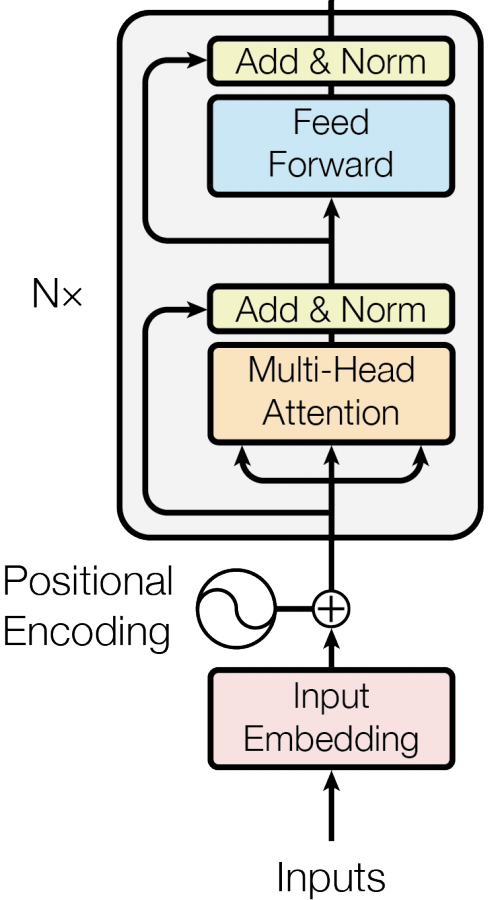


![](https://paperswithcode.com/method/multi-head-attention)

* The diagram shows applying the positional encoding to the original input,   and push it through a stack of $N$ transformer blocks which expects inputs of shape $(T, B, D)$, requires swapping the time and batch dimensions.

<!--[TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)-->

In [ ]:
class EncoderTransformer(nn.Module):
    def __init__(self, H, n_head=8, n_layers=1, dropout=0.5):
        super(EncoderTransformer, self).__init__()
      
        self.pos_encoder = PositionalEncoding(HIDDEN_SIZE, dropout)

        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=HIDDEN_SIZE, nhead=n_head), num_layers= n_layers)


    def forward(self, embedded, input_mask):

        embedded = self.pos_encoder(embedded)
        
        """
        enc_outs : (T, B, H)
        """
        enc_outs = self.encoder(embedded, input_mask)


        return enc_outs

# **DecoderTransformer**

* For decoder I have used `TransformerDecoder`, and ***`GPT2LMHeadModel`***(i.e. `distilgpt2`) for decoding one step at a time in a token-by-token fashion.

> * ***GPT2LMHeadModel*** : "*The GPT2 Model transformer with a language modeling head on top.*"

* It applies positional encoding on transformer encoder outcome to include information about sequence ordering to have improved result.

* `TransformerDecoder` takes as input, a positional encoded sequence, a transformer encoder outcome as context/memory and a boolean mask to indicate presence of data among padded sequence.

* Transormer has in-built multiheaded attention.

* Input embedding for GPT2 decoders ***`GPT2LMHeadModel`*** is populated from the above layers outcome.
          
* Decode outcome from ***`GPT2LMHeadModel`*** is passed as next deoder input input for further prediction of next token.

* The _DecoderTransformer_ produces predictions for the answer sequence, $\boldsymbol{\hat{A}} = \boldsymbol{\hat{a}}_1, \boldsymbol{\hat{a}}_1, \ldots, \boldsymbol{\hat{a}}_T$. Cross-entropy loss is calculated between $\boldsymbol{\hat{Y}}$ and $\boldsymbol{Y}$. 

* The return from the decoder stage predicted token.

<!-- [TransformerDecoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html#transformerdecoder)

[Torch BMM](https://pytorch.org/docs/stable/generated/torch.bmm.html) -->

In [ ]:
class DecoderTransformer(nn.Module):
    def __init__(self, hidden_size, n_head=8, n_layers=1, dropout=0.5):
        super(DecoderTransformer, self).__init__()

        self.pos_decoder = PositionalEncoding(EMBEDDING_SIZE, dropout)
        self.output_mask = None

        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=EMBEDDING_SIZE, nhead=n_head), num_layers=n_layers)
        
        self.gpt_model = GPT_MODEL


    def forward(self, enc_memory, batch_size,  answer, decode_steps, is_teacher_forcing):
        
        """
        output_seq  : (T, B, H)
        """
        output_seq = self.pos_decoder(enc_memory)

        if self.output_mask is None or self.output_mask.size(0) != output_seq.size(0):
            self.output_mask = nn.Transformer().generate_square_subsequent_mask(output_seq.size(0)).to(output_seq.device)
        
        """
        (T, B, H)
        """
        decoded_in = self.decoder(tgt = output_seq, memory = enc_memory, tgt_mask = self.output_mask)
        
        """
        Either Teacher Forcing OR Auto-Regressive.
        """
        teacher_forcing = random.random() < is_teacher_forcing

        h_previous = None
        preds = torch.zeros(decode_steps, batch_size, GPT_VOCAB_SIZE, device=device) 
      
        """
        (B, T, H) Initial step 
        """
        h_decoded_outs, h_previous = self.gpt_model(input_ids=None, inputs_embeds=decoded_in.permute(1, 0, 2), past=h_previous)

        for decode_step in range(decode_steps):
            if decode_step > 0:
                  if self.training and teacher_forcing:
                      decoded_in = answer[decode_step].unsqueeze(0)
                  
                  h_decoded_outs, h_previous = self.gpt_model(decoded_in.permute(1, 0), past=h_previous)

            h_decoded_outs = h_decoded_outs.permute(1, 0, 2)
            
            preds[decode_step] = h_decoded_outs[-1]
            """
            Next token is the decoder input for next time step further time step's token prediction. 
            """
            decoded_in = torch.argmax(h_decoded_outs[-1], 1).unsqueeze(0)

        return preds

# **Fine tunning of GPT2 in Seq2Seq Model**

***Components :***

* I have used ***`DistilBertModel`***(i.e. `distilbert-base-uncased`) layer to convert tokens into feature vectors.

> ***Bert*** : "*Bidirectional Encoder Representations from Transformers*"

> ***DistilBERT*** : "*DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter.*"

* Next, for encoder I have used `nn.TransformerEncoder`, an encoding transformer that takes a tensor of shape $(T, B, D)$ . It expects all $T$ items at once.

* For decoder I have used `nn.TransformerDecoder`, and ***`GPT2LMHeadModel`***(i.e. `distilgpt2`). It generates the output one item at a time.

> * ***GPT2LMHeadModel*** : "*The GPT2 Model transformer with a language modeling head on top.*"

* **Auto-Regressive :**
  * This approach uses predicted token at time step $t$ as the input for the next time step $t+1$ by sampling the next token based on the probabilities. 
  * The auto-regressive approach can be slower to learn, but makes the model *generalize better* as there is no need to provide an answer like in teacher forcing. 
  *  Auto-regressive approach is used in testing as teacher forcing requires knowing the answer. For prediction, I used the auto-regressive approach since teacher forcing requires us to know the answer.

* **Teacher Forcing :** 
  * In this approaching instead of  using the prediciton $\boldsymbol{\hat{a}}_t$ as the input for $\boldsymbol{\hat{a}}_{t+1}$, the true correct token $\boldsymbol{a}_t$ is used. 
  * The Teacher Forcing approach gives the model the _correct_ token at a time step and allows it to continue it's predictions for the next token. This approach makes it easier to predict all subsequent tokens correctly.

* ***For DistilBertModel's frozen weights***, used the `with torch.no_grad():` context instead of manually setting each parameters to `requires_grad=False`. This has the same effect of computing gradients but forgetting them immediately so that gradient updated does not occur.

In [ ]:
class GPTSeq2Seq(nn.Module):
    def __init__(self, H=1024, n_residual_blocks=3, dropout=0.5, decode_steps=22):
        super(GPTSeq2Seq, self).__init__()
        
        self.decode_steps = decode_steps 
        
        self.bert_embedding = BERT_MODEL
        self.input_mask = None

        self.encoder = EncoderTransformer(H) 
        self.decoder = DecoderTransformer(H) 

    def forward(self, question, answer): 

        """
        Embedding
        (T, B) to (T, B, H)

        inputs : (T,B).
        Bert takes (B,T).
        Transformer takes tensor of (T,B,H) Shape. Hence again swap dimension.
        embedded : (T, B, H)
        """
        with torch.no_grad():
            embedded = self.bert_embedding(question.permute(1, 0))[0].permute(1, 0, 2) 

        if self.input_mask is None or self.input_mask.size(0) != question.size(0):
            self.input_mask = nn.Transformer().generate_square_subsequent_mask(question.size(0)).to(question.device) 
        
        """
        Encoding
        """
        enc_memory = self.encoder(embedded, self.input_mask)
        
        """
        Decoding 
        """
        decode_steps = self.decode_steps
        """
        Training : Given Question and Answer pairs gives exact decode length.
        Testing  : Given decode_steps.
        """
        if answer is not None: 
            decode_steps = answer.size(0) - 1

        
        """
        Either Teacher Forcing OR Auto-Regressive
        """
        teacher_forcing_ratio = 1 if self.training else 0

        prediction = self.decoder(enc_memory, question.size(1), answer, decode_steps , teacher_forcing_ratio)
        

        return prediction

gpt_seq2seq_model = GPTSeq2Seq()

def show_model_architechture(model_dict):
    """
    Show GPT2 Seq2seq models architechture.
    """
    print("*"*100)
    print("GPT2 SEQ2SEQ Models Architechture".rjust(65)) 
    print("*"*100 + "\n\n")

    for m in model_dict:
        print("*"*100)
        print(m.rjust(55))
        print("*"*100)
        print(model_dict[m])
        print("*"*100)
        print('\n\n')


"""
Show the structure of all of the models of GPT2 Seq2seq models
"""
show_model_architechture({'GPT2_SEQ2SEQ':gpt_seq2seq_model})

****************************************************************************************************
                                GPT2 SEQ2SEQ Models Architechture
****************************************************************************************************


****************************************************************************************************
                                           GPT2_SEQ2SEQ
****************************************************************************************************
GPTSeq2Seq(
  (bert_embedding): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropou

**Weight initialization and Freeze the BERT and GPT parameters**

  * _Weight_freezing_ for not alter the parameters/coefficients of a layer. Gradients will still be calculated and back propagated through the layer, but when performing gradient descent updates make no change - as if we set the learning rate $\eta=0$. 

  * It is not possible to use weight freezing for _all_ layers of the network, that would mean there is nothing to train. Training is only meaningful if we are going to adjust at least some of the parameters of the model. We will freeze the weights for `bert`, `gpt` layers, and only change the weights of other layers added by me for fine tuninng. This implicitly assumes that the filters learned by bert and gpt2 are _better_ .

  * To do this, setting the `requires_grad` flag for every parameter in our model to `False` for `bert`, `gpt` layers. This will make it so that no parameter will save a gradient after back-propagation, and thus no changes will occur when the optimizer performs the update step. 

**Optimizer And Loss Function**

  * I have used `nn.CrossEntropyLoss`.
  * This model's last prediction should be EOS token and it should not proceed for predicting padding. If the label $y=\text{ignore_index}$, the `nn.CrossEntropyLoss` will not calculate any loss for that value.

In [ ]:
"""
Weight initialization
""" 
def frozen_weights_init(m):
    for parameter_name, parameter in m.named_parameters():
        for w in ['bert.', 'gpt.']:
            if parameter_name.find(w) != -1:
                parameter.requires_grad = False
        if parameter.requires_grad:
            nn.init.normal_(parameter.data, mean=0, std=0.01)

frozen_weights_init(gpt_seq2seq_model)

optimizer = torch.optim.AdamW(gpt_seq2seq_model.parameters())

loss_func = nn.CrossEntropyLoss(ignore_index= PAD)

# **About training a neural network for chatbots**

Let's denote $\boldsymbol{x}$ as input feature, and $f()$ to denote model. If there is a label associated with $\boldsymbol{x}$, then we will denote it as $y$. Our model takes in $\boldsymbol{x}$, and produces a prediction $\hat{y}$. This becomes $\hat{y} = f(\boldsymbol{x})$. The model needs to adjust some parameters to provide better predictions thus generating a better model. If $\Theta$ denotes _all_ the parameters of a model. $\hat{y} = f_\Theta(\boldsymbol{x})$ represent that the model's behavior is dependent on the value of it's parameters $\Theta$ also known as the "state" of the model.

Our goal for training is to minimize the _loss function_ which _quantifies_ just how badly the model is doing at the goal of predicting the ground truth $y$. If $y$ is goal, and $\hat{y}$ is the prediction, then loss function is denoted by $\ell(y, \hat{y})$. If there is a training set with $N$ examples, the equation is:

$$\min_{\Theta} \sum_{i=1}^N \ell(f_\Theta(\boldsymbol{x}^{(i)}), y^{(i)}) $$

The summation ($\sum_{i=1}^N$) is going over all $N$ pairs of input ($\boldsymbol{x}^{(i)}$) and output ($y^{(i)}$), and determining just how badly ($\ell(\cdot,\cdot)$) are doing. To create the best possible model $\Theta$ is adjusted using gradient descent. If $\Theta_k$ is the _current_ state of our model, which needs to improve, then the next state $\Theta_{k+1}$, that hopefully reduces the loss of the model in terms of a mathematical equation is:

$$\Theta_{k+1} = \Theta_k - \eta \cdot \frac{1}{N} \sum_{i=1}^{N} \nabla_{\Theta}\ell(f_{\Theta_k}(\boldsymbol{x}^{(i)}), y^{(i)})$$

The above equation shows the mathematical representation for _gradient decent_. We follow the gradient ($\nabla$) to tell us how to adjust $\Theta$. As PyTorch provides us APIs to perform differentiation, we can easily compute $\nabla_{\Theta}$ and don't have to keep track of everything inside of $\Theta$. $\eta$ is learning rate or the step size.

For training we _need_ :
1. Model $f(\cdot)$ to compute
$f_\Theta(\boldsymbol{x}^{(i)})$
 which I have done for creating my GPTSeq2Seq model for the chatbot.
2. PyTorch stores gradients in a mutable data structure. To set a clean state before we use the data structure I have used optimizer.zero_grad().
3. Loss function $\ell(\cdot,\cdot)$ is used to compute loss.
4. loss.backward() is used to compute gradient $\nabla_{\Theta}$ .
5. optimizer.step() is used to update all parameters and to perform Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y) 

$$\Theta_{k+1} = \Theta_k - \eta \cdot \frac{1}{N} \sum_{i=1}^{N} \nabla_{\Theta}\ell(f_{\Theta_k}(\boldsymbol{x}^{(i)}), y^{(i)})$$
6. Finally, I have computed the loss generating my graph plots.

In [ ]:
def train_gpt_seq2seq(model, loss_func, train_iterator, val_iterator=None, 
                      epochs=50, device="cpu", optimizer=None):
  
    to_track = ["epoch", "total time", "train loss"]
    if val_iterator is not None:
        to_track.append("val loss")
     
    total_train_time = 0 
    results = {}
    for item in to_track:
        results[item] = []

    """
    Place the model on the correct compute resource (CPU or GPU)
    """
    model.to(device)
 
    best_val_loss = float('inf')

    for epoch in tqdm(range(epochs), desc="Epoch", disable=False):
        """
        Put our model in training mode
        """
        model = model.train()
        BERT_MODEL.eval()
        GPT_MODEL.eval()
        running_loss = 0.0
        
        start = time.time()
        for i, batch in enumerate(tqdm(train_iterator, desc="Train Batch Iterator", leave=False, disable=False)):

            question = batch.source
            answer = batch.target
            """
            PyTorch stores gradients in a mutable data structure. So need to set it to a clean state to prevent
            getting old information from a previous iteration.
            """
            optimizer.zero_grad()

            """
            This just computed f_Θ(x(i))
            target : (T, B)
            y_hat : (T, B, D)
            """
            y_hat = model(question              = question,
                          answer                = answer)
            """
            Compute loss.
            """
            loss = loss_func(y_hat.view(-1, y_hat.shape[-1]), answer[1:].view(-1))
            """
            Compute ∇_Θ.
            """
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

            """
            Now need to update all the parameters.
            Θ_{k+1} = Θ_k − η * ∇_Θ ℓ(y_hat, y)
            """  
            optimizer.step()
            """
            Capture Training Loss to plot it.
            """
            running_loss += loss.item()
        
        """
        end training epoch
        """
        end = time.time()
        total_train_time += (end-start)
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        results["train loss"].append( (running_loss/len(train_iterator)) )


        if val_iterator is None:
            pass
        else:
            """
            Set the model to evaluation mode to prevent any updates.
            """
            model = model.eval()
            
            val_running_loss = 0.0

            for i, batch in enumerate(val_iterator):
                question = batch.source
                answer = batch.target

                y_hat = model(question              = question,
                              answer                = answer )

                
                loss = loss_func(y_hat.view(-1, y_hat.shape[-1]), answer[1:].view(-1))
                """
                Capture validation Loss.
                """
                val_running_loss += loss.item()
                        
            
            results["val loss"].append( (val_running_loss/len(val_iterator)) )
        
            if val_running_loss < best_val_loss:
                """
                Save best Model in separate checkpoint file.
                """
                torch.save(model.state_dict(), chatbot_checkpoint_dir + 'QA_GPT_Seq2seq_ChatBot_BestModel.pt')

                best_val_loss = val_running_loss
       
    """
    Save Model in a checkpoint file.
    """
    torch.save(model.state_dict(), chatbot_checkpoint_dir + 'QA_GPT_Seq2seq_ChatBot.pt')      
               
    result_df = pd.DataFrame.from_dict(results)
    result_df.to_csv(chatbot_checkpoint_dir + "QA_GPT_Seq2seq_Results.csv") 
    
    return result_df


In [ ]:
import torch
torch.cuda.empty_cache()


result_df = train_gpt_seq2seq(model                      = gpt_seq2seq_model, 
                              loss_func                  = loss_func, 
                              train_iterator             = train_iterator, 
                              epochs                     = 4, 
                              device                     = device,
                              optimizer                  = optimizer         
                              )

## **Plot Losses During Training**

* The losses from the model training clearly show a decreasing trend indicating that my training is working.

In [ ]:
"""
Load State Dict
"""
checkpointFile =  chatbot_checkpoint_dir + 'QA_GPT_Seq2seq_ChatBot.pt'
loaded_checkpoint = torch.load(checkpointFile)

gpt_seq2seq_model.load_state_dict(loaded_checkpoint)

gpt_seq2seq_model = gpt_seq2seq_model.eval()

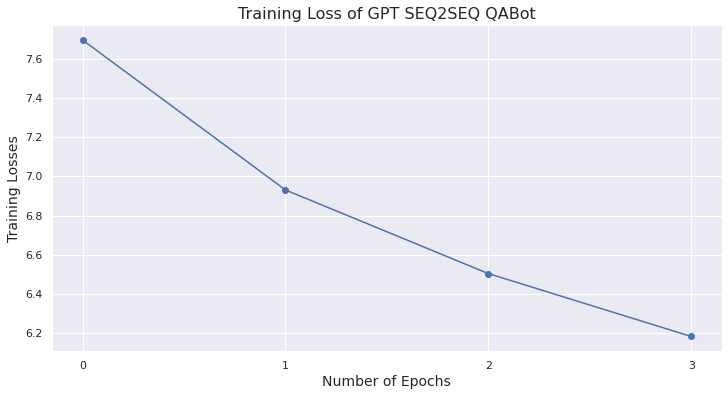

In [ ]:
"""
GPTSeq2seq ChatBot Training Losses
"""

loaded_results_df = pd.read_csv(chatbot_checkpoint_dir + "QA_GPT_Seq2seq_Results.csv")
sns.set(style='darkgrid') 
plt.figure(figsize=(12,6))
plt.plot(loaded_results_df['train loss'], 'b-o') 
plt.title("Training Loss of GPT SEQ2SEQ QABot", fontsize=16)
plt.xlabel('Number of Epochs', fontsize=14)
plt.xticks(range(4))
plt.ylabel('Training Losses', fontsize=14)
plt.show()

# **Evaluation : Test Results**

In [ ]:
"""
Load saved model
"""
gpt_seq2seq_model = GPTSeq2Seq()
gpt_seq2seq_model.load_state_dict(torch.load(chatbot_checkpoint_dir + 'QA_GPT_Seq2seq_ChatBot.pt'))

<All keys matched successfully>

In [ ]:
getQuestion = lambda x : BERT_TOKENIZER.decode(x.tolist()) 
getSentence = lambda x : GPT_TOKENIZER.decode(x.tolist()) 

gpt_seq2seq_model = gpt_seq2seq_model.eval().to(device)

In [ ]:
def getPrediction(model,idx_lst):
    
    answers, pred_answers = [], []

    for i, batch in tqdm(enumerate(test_iterator), desc="Predict", disable=False):
      
        question_tensor, answer_tensor = batch.source, batch.target

        with torch.no_grad():
            predictions = model(question              = question_tensor,
                                answer                = answer_tensor)
        
        question_s, answer_s, pred_ans = getQuestion(question_tensor[:,0]), getSentence(answer_tensor[:,0]), getSentence(torch.argmax(predictions[:, 0, :], 1))

        answers.append(answer_s[:-1])
        pred_answers.append(pred_ans)

        if i in idx_lst:
          print("\nAnswer :    ", answer_s,"\nPredicted : ", pred_ans)
          print("*"*100,"\n\n")

"""
Predictions
"""
print("*"*15)
print("Predictions :")
print("*"*15)
getPrediction(gpt_seq2seq_model, [12,15,18,20,22,34,88,98,95,100,165,189,190,398,555,879,980,999])

***************
Predictions :
***************



Answer :     <|endoftext|>it is a publicly traded limited partnership<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
Predicted :  the average number of the average of the average temperature in the average temperature in f in f f f f f f f f f f f
**************************************************************************************************** 



Answer :     <|endoftext|>batavia is in clermont county ohio<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoft

In [ ]:
def getPrediction(model,idx_lst):
    
    answers, pred_answers = [], []

    for i, batch in tqdm(enumerate(test_iterator), desc="Predict", disable=False):
      
        question_tensor, answer_tensor = batch.source, batch.target

        with torch.no_grad():
            predictions = model(question              = question_tensor,
                                answer                = answer_tensor)
        
        question_s, answer_s, pred_ans = getQuestion(question_tensor[:,0]), getSentence(answer_tensor[:,0]), getSentence(torch.argmax(predictions[:, 0, :], 1))

        answers.append(answer_s[:-1])
        pred_answers.append(pred_ans)

        if i in idx_lst:
          print("\nAnswer :    ", answer_s,"\nPredicted : ", pred_ans)
          print("*"*100,"\n\n")

"""
Predictions
"""
print("*"*15)
print("Predictions :")
print("*"*15)
getPrediction(gpt_seq2seq_model1, [12,15,18,20,22,34,88,98,95,100,165,189,190,398,555,879,980,999])

***************
Predictions :
***************



Answer :     <|endoftext|>moody s synonyms are saturnine dour morose sour dark ill natured glum glowering sullen working<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
Predicted :  the be the united of the united of the united of the united to the united to the united to the united to the united to the united of the united to the united to the united to the united to the united to the united to
**************************************************************************************************** 



Answer :     <|endoftext|>the most densely populated census tract chicago is people per square mile<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|> 
Predicted :  the be the united of the united of the united of the united to the united to 

# **Evaluation Matrix for GPT2 Fine tuned Seq2seq Model**

# **Bleu Score**

* From `test_iterator` getting `question_tensor`, `answer_tensor`.

* Passing `question_tensor` to gptseq2seq model in eval mode and with `torch.no_grad()` to prevent gradient updation. This gives predicted answer tensor.

* Converting predicted answer tensor and `answer_tensor` to string using `GPT_TOKENIZER`.

* Computing the BLEU score between a candidate answer and a predicted answer.

In [ ]:
def calculateBleuScore(model):
    
    answers, pred_answers = [], []
    
    for i, batch in tqdm(enumerate(test_iterator), desc="BLEU", disable=False):
        
        question_tensor, answer_tensor = batch.source, batch.target

        with torch.no_grad():
            predictions = model(question              = question_tensor,
                                answer                = answer_tensor)
            
        answer_s , pred_ans = getSentence(answer_tensor[:,0]), getSentence(torch.argmax(predictions[:, 0, :], 1))
        
        answers.append([answer_s.split(" ")[:-1]])
        pred_answers.append(pred_ans.split(" "))

    return  bleu_score(pred_answers, answers)  

"""
Calculate BLEU Score
"""
bleu = calculateBleuScore(gpt_seq2seq_model)
print('BLEU Score : {:.4f}'.format(bleu))


BLEU Score : 0.3491


# **F1 Score**

* F1 Score takes into account cooccurring words regardless their orders.

* From `test_iterator` getting `question_tensor`, `answer_tensor`.

* Passing `question_tensor` to gptseq2seq model in eval mode and with `torch.no_grad()` to prevent gradient updation. This gives predicted answer tensor.

* Converting predicted answer tensor and `answer_tensor` to string using `GPT_TOKENIZER`.

* Count the number of common words between them.

* Calculate Precesion and Recall.

* Calculate F1 Score based on the following formula.

* **F1 Score :**   
$$
\frac{2 \times precession \times recall}{precession + recall}
$$

In [ ]:
def calculate_f1_score(model):
    f1_scores = []
    for i, batch in tqdm(enumerate(test_iterator), desc="F1 Score", disable=False):
      
        question_tensor, answer_tensor = batch.source, batch.target

        with torch.no_grad():
            predictions = model(question              = question_tensor,
                                answer                = answer_tensor)

        answer_s, pred_ans = getSentence(answer_tensor[:,0]), getSentence(torch.argmax(predictions[:, 0, :], 1))

        number_of_common_words = sum((collections.Counter(answer_s.split(" ")) & collections.Counter(pred_ans.split(" "))).values())

        if number_of_common_words == 0:
            f1_score =  0
        else:
            precision = 1.0 * number_of_common_words / len(pred_ans)
            recall = 1.0 * number_of_common_words / len(answer_s)
            f1_score = (2 * precision * recall) / (precision + recall)
            
        f1_scores.append(f1_score)
    return f1_scores

f1_scores = calculate_f1_score(gpt_seq2seq_model)
f1_score = sum(f1_scores)/len(f1_scores)
print('F1 Score : {:.4f}'.format(f1_score))


F1 Score : 0.4363


# **Rouge L Score**

[RougeL](https://www.aclweb.org/anthology/W04-1013.pdf)

> "Recall-Oriented Understudy for Gisting Evaluation. It includes measures to automatically determine the quality of a summary by comparing it to other (ideal) summaries created by humans. The measures count the number of overlapping units such as n-gram, word sequences, and
word pairs between the computer-generated summary to be evaluated and the ideal summaries created by humans. 

> "Given two sequences X and Y, the longest common subsequence (LCS) of X and recall reflects the proportion of words in X (reference summary sentence) that are also present in Y (candidate summary sentence); while unigram precision is the proportion of words in Y that are also in X. Unigram recall and precision count all cooccurring words regardless their orders; while
ROUGE-L counts only in-sequence co-occurrences."

ROUGE-L is one type of ROUGE measures. It is calculated by taking into account longest common subsequence (LCS) between two sequences.It counts only in-sequence co-occurrences.

* From `test_iterator` getting `question_tensor`, `answer_tensor`.

* Passing `question_tensor` to gptseq2seq model in eval mode and with `torch.no_grad()` to prevent gradient updation. This gives predicted answer tensor.

* Converting predicted answer tensor and `answer_tensor` to string using `GPT_TOKENIZER`.

* Computing the Rouge-L score between a candidate answer and a predicted answer by getting longest common subsequence (LCS) between the two sequences.

* **Applying ROUGE-L Score Formula :** 
$$
\frac{(1+\beta^2) \times R \times P}{R + \beta^2 \times P}
$$

In [ ]:
def longest_common_subsequence(str1, str2):
        
    """
    Makeing a grid of 0's with len(str2) + 1 columns  and len(str1) + 1 rows.
    """
    dp = [[0] * (len(str2) + 1) for _ in range(len(str1) + 1)]
    
    """
    Iterate up each column, starting from the last one.
    """
    for col in reversed(range(len(str2))):
        for row in reversed(range(len(str1))):
            
            if str2[col] == str1[row]:
                """
                If the corresponding characters for this cell are the same.
                """
                dp[row][col] = 1 + dp[row + 1][col + 1]
            
            else:
                """
                Otherwise they must be different.
                """
                dp[row][col] = max(dp[row + 1][col], dp[row][col + 1])
    
    """
    The original problem's answer is in dp[0][0]. Return it.
    """
    return dp[0][0]
    
def rougel_score(ans, pred):
    
    BETA, answers, pred_answers = 1.2, [], []
        
    if len(pred)!=1 and len(ans)<=0:
        return        
    

    for idx in range(min(len(pred),len(ans))):
        pred_words, ans_words = pred[idx], ans[idx]
        long_cmmn_subseq = longest_common_subsequence(ans_words, pred_words)
        answers.append(long_cmmn_subseq/float(len(ans_words)))
        pred_answers.append(long_cmmn_subseq/float(len(pred_words)))
        
    max_ans, max_pred = max(answers), max(pred_answers)


    return ((1 + BETA**2)* max_pred * max_ans)/float(max_ans + BETA**2 * max_pred) if (max_ans !=0 and max_pred !=0) else 0.0
  
def calculateRougeLScore(model):
    
    answers, pred_answers = [], []

    for i, batch in tqdm(enumerate(test_iterator), desc="ROUGE-L", disable=False):
      
        question_tensor, answer_tensor = batch.source, batch.target

        with torch.no_grad():
            predictions = model(question              = question_tensor,
                                answer                = answer_tensor)

        answer_s, pred_ans = getSentence(answer_tensor[:,0]), getSentence(torch.argmax(predictions[:, 0, :], 1))

        answers.append([answer_s.split(" ")[:-1]])
        pred_answers.append(pred_ans.split(" "))

    return rougel_score(answers, pred_answers)


"""
Calculate ROUGE-L Score
"""
rouge_l_score= calculateRougeLScore(gpt_seq2seq_model)
print('ROUGE-L Score : {:.4f}'.format(rouge_l_score))


ROUGE-L Score : 0.5265


## **Chat**

***Start Conversation with the Bot***

[Write TSV](https://riptutorial.com/python/example/26946/writing-a-tsv-file)



In [ ]:
gpt_seq2seq_model = gpt_seq2seq_model.to(device).eval()

def get_response(model, question_asked):

    data_file = chatbot_data_dir + 'question_asked'

    tsv_writer = csv.writer(open(data_file, 'w', encoding='utf-8', newline=''), delimiter='\t')
    tsv_writer.writerow([question_asked])
    SOURCE = getField(BERT_TOKENIZER, False)

    question_data = data.TabularDataset(path=data_file + '.tsv',
                                        format='tsv',
                                        skip_header=False,
                                        fields= [('source', SOURCE)])
    iterator = data.BucketIterator(question_data,
                                    batch_size=BATCH_SIZE,
                                    sort_key=lambda x: len(x.source),
                                    sort_within_batch=False,
                                    device=device)
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            question_tensor = batch.source

            """
            pred : (T, B, H)
            """
            prediction = model(question_tensor, None)
            
            pred_s = getSentence(torch.argmax(prediction[:, 0, :], 1))
            return pred_s


question = ''
print('Bot : Hi, Did you want to chat with me?')

while question.lower()[:3] != 'bye':
  try:
    while True:
        print('Me : ', end='')
        question = input()
        if question:
            break
    if question.lower()[:3] != 'bye':
        response = get_response(gpt_seq2seq_model.to(device).eval(), question)
        print('Bot: ' + response)
    else:
        print('Bot : Bye!! Stay safe. Have a nice day.')
  except KeyError:
            print("Sorry, I am not sure what you are talking about :/")



Bot : Hi, Did you want to chat with me?
Me: what is corporation?
Bot: the the average time to the first day of
Me: bye
Bot: Bye!! Stay safe. Have a nice day.
